In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Sun/ML Shock/Final project/

/content/drive/MyDrive/Sun/ML Shock/Final project


# Convolutional Neural Networks


In [3]:
import sys
# sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [4]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from CustomDatasetNPY import CustomDataset
from torch.utils.data import DataLoader

from scipy.special import kl_div

import os

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the Data

In [6]:
# Load (train or test) data from csv file
# path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/sample_data/"
# path_df = "C:/Users/Amy/Desktop/Green_Git/eegClassification/files/"
# scaler_path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/models/scalers/"

path = "./data_prep/"
path_df = "./"
scaler_path = "./data/"
path_model = "./model_custom_spec_v2.pt"


In [7]:
# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# Type of mscale
scaler_type = "min_max" #"standard" #
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

In [8]:
if data_type == "spec":
    input_shape = (4,299,100)
elif data_type == "eeg_spec":
    input_shape = (20,129,43)
elif data_type == "eeg_raw":
    input_shape = (20,9800)

In [9]:
# # load scaler from pickle
# import pickle
# scaler_name = data_type + "_" + scaler_type + "_scaler" + ".pkl"
# scaler = pickle.load(open(scaler_path + scaler_name, 'rb'))

In [10]:
# Data transform to convert data to a tensor and apply scaler
# no data augmentation
# transform = (lambda x: scaler.transform(x.reshape(1,-1)).reshape(*input_shape),)
transform = tuple()

In [11]:
# def load_data(path, path_df, data_type, text):

#     train=True
#     df = pd.read_csv(path_df + f"{text}_processed.csv")



#     data_dir = (
#         f"train_eegs/"
#         if "eeg" in data_type
#         else f"train_spectrograms/"
#     )
#     data_dir = path + data_dir

#     ###
#     # files = os.listdir(data_dir)
#     # df = df[
#     #     df["eeg_id" if "eeg" in data_type else "spectrogram_id"].isin(
#     #         [int(f.split(".")[0]) for f in files]
#     #     )
#     # ]
#     ###

#     votes_cols = [
#         "seizure_vote",
#         "lpd_vote",
#         "gpd_vote",
#         "lrda_vote",
#         "grda_vote",
#         "other_vote",
#     ]
#     label_cols = (
#         ["eeg_id", "label_id", "eeg_label_offset_seconds"]
#         if "eeg" in data_type
#         else ["spectrogram_id", "label_id", "spectrogram_label_offset_seconds"]
#     )
#     offset = (
#         ["eeg_label_offset_seconds"]
#         if "eeg" in data_type
#         else ["spectrogram_label_offset_seconds"]
#     )

#     # if info_cols not in df add it and set to zero
#     for col in offset:
#         if col not in df.columns:
#             df[col] = 0
#     # if df does not contain "label_id" add a unique label_id
#     if "label_id" not in df.columns:
#         df["label_id"] = range(len(df))

#     info = {}
#     df_gr = df.groupby(label_cols)
#     for name, group in df_gr:
#         # first row of group
#         info[name] = {"votes": group[votes_cols].values[0] if train else None}

#     return data_dir, data_type, info


In [12]:
# data_dir, data_type, info = load_data(path, path_df, data_type, "train")
# data_dir, data_type, len(info)

In [13]:
# train_data = CustomDataset(data_dir, data_type, info, transform=transform)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [14]:
train_data = CustomDataset(data_path = path+'train/', N_items = 101, transform=transform)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [15]:
# data_dir, data_type, info_val  = load_data(path, path_df, data_type, "val")
# data_dir, data_type, len(info_val)

In [16]:
# valid_data = CustomDataset(data_dir, data_type, info_val, transform=transform)
# valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [17]:
valid_data = CustomDataset(data_path = path+'valid/', N_items = 35, transform=transform)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [18]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)
classes

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [19]:
x_transform = lambda x,y,z: (transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225])(x[0,:]), y[0,:], z[0,:])

In [20]:
%%time
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels, votes = next(dataiter)
images, labels, votes = x_transform(images, labels, votes)
# images = images.numpy() # convert images to numpy for display
# images.shape

CPU times: user 19.6 ms, sys: 68 ms, total: 87.7 ms
Wall time: 295 ms


In [21]:
labels.shape, votes.shape, images.shape

(torch.Size([64]), torch.Size([64, 6]), torch.Size([64, 4, 299, 100]))

In [22]:
np.min(images.numpy().reshape(batch_size, -1)), np.max(images.numpy().reshape(batch_size, -1))

(-2.117904, 75.25443)

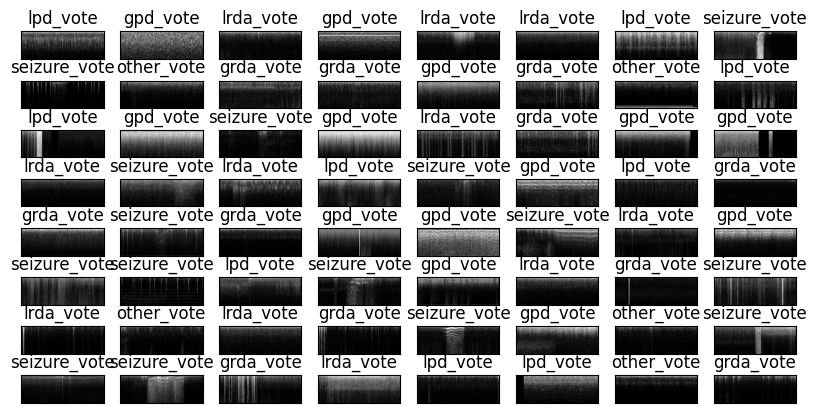

In [23]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 5))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    # show black and white images
    ax.imshow(images[idx][0,:,:].T, cmap='gray')
    ax.set_title(classes[labels[idx]])


## Define the Network Architecture


In [41]:
# # define the CNN architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # convolutional layer (sees 32x32x3 image tensor)
#         self.conv1 = nn.Conv2d(input_shape[0], 8, 3, padding=1)
#         # convolutional layer (sees 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
#         # convolutional layer (sees 8x8x32 tensor)
#         self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
#         # max pooling layer
#         self.pool = nn.MaxPool2d(2, 2)
#         # linear layer (64 * 4 * 4 -> 500)
#         self.N_out = 16*(input_shape[1]//2//2//2)*(input_shape[2]//2//2//2)
#         self.fc1 = nn.Linear(self.N_out, 500)
#         # linear layer (500 -> 10)
#         self.fc2 = nn.Linear(500, N_classes)
#         # dropout layer (p=0.25)
#         self.dropout = nn.Dropout(0.25)

#     def forward(self, x):
#         # add sequence of convolutional and max pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.dropout(x)
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.dropout(x)
#         x = self.pool(F.relu(self.conv3(x)))
#         # flatten image input
#         x = x.view(batch_size, self.N_out)
#         # add dropout layer
#         x = self.dropout(x)
#         # add 1st hidden layer, with relu activation function
#         x = F.relu(self.fc1(x))
#         # add dropout layer
#         x = self.dropout(x)
#         # add 2nd hidden layer, with relu activation function
#         x = F.log_softmax(self.fc2(x), dim =1)

#         return x

In [47]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(input_shape[0], 8, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.N_out = 16*(input_shape[1]//2//2//2)*(input_shape[2]//2//2//2)
        self.fc1 = nn.Linear(self.N_out, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, N_classes)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(batch_size, self.N_out)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim =1)

        return x

In [48]:
# create a complete CNN
model = Net()
# path_model_old = "./model_custom_v1.pt"
# model.load_state_dict(torch.load(path_model_old))
model

Net(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7104, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [49]:
num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters in the model', num_parameters)

Number of parameters in the model 3559290


In [50]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

### Specify [Loss Function](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss) and [Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)


In [51]:
criterion = nn.KLDivLoss(reduction="batchmean",log_target= True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

---
## Train the Network


In [52]:
import gc
from tqdm import tqdm
# number of epochs to train the model
n_epochs = 30
max_samples = 500

valid_loss_min = np.Inf # track change in validation loss

print('Epoch: \tTraining Loss:  \tValidation Loss:')
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    # count = 0

    for data, label, votes in tqdm(train_loader):
        # if count >= max_samples:
        #     break

        data, label, votes = x_transform(data, label, votes)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
           data, label, votes = data.cuda(), label.cuda(), votes.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # loss
        loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        # count +=1


    torch.cuda.empty_cache()
    ######################
    # validate the model #
    ######################
    model.eval()
    # count = 0
    for data, label, votes in tqdm(valid_loader):
        # if count >= max_samples*0.1:
        #     break

        data, label, votes = x_transform(data, label, votes)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, label, votes = data.cuda(), label.cuda(), votes.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

        # count +=1


    torch.cuda.empty_cache()
    # calculate average losses
    train_loss = train_loss/len(train_loader)/batch_size#/max_samples#
    valid_loss = valid_loss/len(valid_loader)/batch_size#/max_samples/0.1#/

    # print training/validation statistics
    print('{}; \t{:.6f}; \t{:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        # print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        # valid_loss_min,
        # valid_loss))
        torch.save(model.state_dict(), path_model)
        valid_loss_min = valid_loss

    gc.collect()

Epoch: 	Training Loss:  	Validation Loss:


100%|██████████| 35/35 [00:07<00:00,  4.38it/s]


1; 	0.967085; 	1.002322


100%|██████████| 35/35 [00:07<00:00,  4.45it/s]


2; 	0.870603; 	0.950131


100%|██████████| 35/35 [00:08<00:00,  4.20it/s]


3; 	0.819695; 	0.930664


100%|██████████| 35/35 [00:06<00:00,  5.39it/s]


4; 	0.780751; 	0.902390


100%|██████████| 35/35 [00:05<00:00,  6.86it/s]


5; 	0.745328; 	0.890559


100%|██████████| 35/35 [00:05<00:00,  6.35it/s]


6; 	0.714921; 	0.878766


100%|██████████| 35/35 [00:03<00:00, 11.36it/s]


7; 	0.688914; 	0.863920


100%|██████████| 35/35 [00:03<00:00, 10.31it/s]


8; 	0.671564; 	0.852313


100%|██████████| 35/35 [00:02<00:00, 12.08it/s]


9; 	0.647740; 	0.838793


100%|██████████| 35/35 [00:03<00:00, 11.34it/s]


10; 	0.627218; 	0.834691


100%|██████████| 35/35 [00:03<00:00,  9.98it/s]


11; 	0.613870; 	0.815699


100%|██████████| 35/35 [00:03<00:00,  9.47it/s]


12; 	0.590206; 	0.808849


100%|██████████| 35/35 [00:02<00:00, 11.72it/s]


13; 	0.571880; 	0.824081


100%|██████████| 35/35 [00:02<00:00, 11.91it/s]


14; 	0.558885; 	0.812726


100%|██████████| 35/35 [00:02<00:00, 11.73it/s]


15; 	0.543618; 	0.802942


100%|██████████| 35/35 [00:02<00:00, 12.02it/s]


16; 	0.530707; 	0.802406


100%|██████████| 35/35 [00:02<00:00, 11.78it/s]


17; 	0.514331; 	0.791076


100%|██████████| 35/35 [00:02<00:00, 11.73it/s]


18; 	0.502140; 	0.794276


100%|██████████| 35/35 [00:03<00:00, 10.66it/s]


19; 	0.491975; 	0.789961


100%|██████████| 35/35 [00:03<00:00,  9.38it/s]


20; 	0.477674; 	0.808659


100%|██████████| 35/35 [00:03<00:00,  9.56it/s]


21; 	0.468562; 	0.807247


100%|██████████| 35/35 [00:03<00:00, 10.73it/s]


22; 	0.452526; 	0.785174


100%|██████████| 35/35 [00:03<00:00, 11.47it/s]


23; 	0.444509; 	0.809145


100%|██████████| 35/35 [00:02<00:00, 11.69it/s]


24; 	0.436375; 	0.791503


100%|██████████| 35/35 [00:02<00:00, 11.82it/s]


25; 	0.430183; 	0.802610


100%|██████████| 35/35 [00:02<00:00, 11.73it/s]


26; 	0.416149; 	0.784187


100%|██████████| 35/35 [00:02<00:00, 11.98it/s]


27; 	0.406836; 	0.796048


100%|██████████| 35/35 [00:03<00:00, 10.67it/s]


28; 	0.402933; 	0.794098


100%|██████████| 35/35 [00:03<00:00,  9.36it/s]


29; 	0.389726; 	0.799122


100%|██████████| 35/35 [00:03<00:00,  9.86it/s]


30; 	0.384544; 	0.787048


###  Load the Model with the Lowest Validation Loss

In [53]:
model.load_state_dict(torch.load(path_model))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [54]:
# data_dir, data_type, info_test = load_data(path, path_df, data_type, "test")
# data_dir, data_type, len(info_test)

In [55]:
# test_data = CustomDataset(data_dir, data_type, info_test, transform=transform)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [56]:
test_data = CustomDataset(data_path = path+'test/', N_items = 35, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [57]:
# track test loss
test_loss = 0.0
test_loss_baseline = 0.0
class_correct = list(0. for i in range(N_classes))
class_total = list(0. for i in range(N_classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()

cm_y_pred = []
cm_y_true = []
# iterate over test data
# count = 0
for data, target, votes in tqdm(test_loader):
    # if count >= max_samples*0.1:
    #   break
    # count+=1

    data, target, votes = x_transform(data, target, votes)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target, votes = data.cuda(), target.cuda(), votes.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
    # dummy is a tensor filled with 1/6 of shape [64,6]
    dummy = torch.ones(data.size(0), N_classes).to(device)
    dummy = dummy/N_classes
    loss_baseline = criterion(output.float(), F.log_softmax(dummy, dim=1))
    # update test loss
    test_loss += loss.item()*data.size(0)
    test_loss_baseline += loss_baseline.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        cm_y_pred.append(pred[i].item())
        cm_y_true.append(target.data[i].item())

# average test loss
print()
test_loss = test_loss/len(test_loader.dataset)#/batch_size#/max_samples/0.1#
print('Test Loss: {:.6f}\n'.format(test_loss))

test_loss_baseline = test_loss_baseline/len(test_loader.dataset)#/batch_size#/max_samples/0.1#
print('Test Loss Baseline: {:.6f}\n'.format(test_loss_baseline))


100%|██████████| 35/35 [00:07<00:00,  4.44it/s]


Test Loss: 49.097760

Test Loss Baseline: 26.880180



In [58]:
for i in range(N_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Accuracy of seizure_vote: 62% (334/534)
Test Accuracy of lpd_vote: 72% (240/331)
Test Accuracy of gpd_vote: 79% (267/334)
Test Accuracy of lrda_vote: 51% (153/298)
Test Accuracy of grda_vote: 38% (133/344)
Test Accuracy of other_vote: 34% (137/399)

Test Accuracy (Overall): 56% (1264/2240)


In [59]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(cm_y_true, cm_y_pred)
print(confusion_matrix)


[[334  79  29  19   7  66]
 [  8 240  26  23   6  28]
 [ 25  17 267   8   6  11]
 [ 18  70   6 153  13  38]
 [ 19  27  66  34 133  65]
 [ 67  71  61  50  13 137]]
